In [2]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

### Read data

In [3]:
data = pd.read_csv('dados_voz_genero.csv', delimiter = ',')
data = data.drop("Unnamed: 0", axis=1)
names = list(data.keys())
data.sample(5)

,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
36,0.067220,0.157240,0.136022,0.209526,0.073505,1.936065,6.334626,0.903982,0.482886,0.134506,0.167648,0.142748,0.016615,0.262295,0.239583,0.007812,0.601562,0.593750,0.347588,1.0
461,0.067387,0.114681,0.078564,0.191569,0.113005,1.687865,7.070532,0.963008,0.727981,0.104069,0.129028,0.106148,0.017998,0.275862,0.104083,0.007812,0.250000,0.242188,0.114839,1.0
919,0.062510,0.217990,0.130221,0.247087,0.116865,2.000917,7.600014,0.899887,0.400099,0.245656,0.192300,0.134046,0.050104,0.279070,0.514453,0.023438,2.578125,2.554688,0.073649,1.0
160,0.068045,0.177171,0.099981,0.217190,0.117209,21.579705,598.392640,0.926462,0.534102,0.060097,0.163180,0.071791,0.016377,0.258065,0.090461,0.070312,0.695312,0.625000,0.054911,1.0
1524,0.069933,0.140259,0.107918,0.219123,0.111204,5.448489,58.052852,0.887048,0.463191,0.000000,0.155083,0.109726,0.015936,0.271186,0.090732,0.007812,0.632812,0.625000,0.132738,1.0


### Check balance

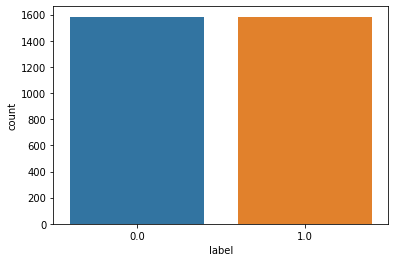

In [4]:
sns.countplot(x='label', data=data)
plt.show()

Data is balanced

### Prepare data

In [5]:
def sigmoid(z):
    import numpy as np
    sigm = 1/(1+np.exp(-z))
    return sigm

def loss(h, y):
    import numpy as np
    loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    return loss

def normalize(x, interval):
    import numpy as np
    x1 = np.array(x)
    x_normalized =  interval[0] + (x1 - min(x))*(interval[1] - interval[0])/(max(x) - min(x))
    return x_normalized

In [6]:
# Divide X and y
names = list(data.keys())

X = data.copy()
left_ones = np.ones(data.shape[0])
X['ones'] = left_ones
X = X.drop(columns = 'label')

cols = list(X.columns)
cols = [cols[-1]] + cols[:-1]
X = X[cols]

for i in range(1,X.shape[1] -1):
    X.iloc[:,i] = normalize(X.iloc[:,i], [-1,1])
    
y = data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Make and train model

In [7]:
# Inicialize weights
VAL_PROPORTION = 0.25
theta = np.zeros(X_train.shape[1])

ls_training = []
ls_val = []

# Learning rate
lr = 0.5

# Threshold
threshold = 0.5

# Number of iterations
iterations = 100000

#Number of additional iterations after a minimum on validation set
MAX_IT_AFTER_MIN = 10000
it_after_min = 0
min_cost_val = 2**10 #high number

# Training loop
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=VAL_PROPORTION, random_state=42)


for i in range(iterations):
    it_after_min = it_after_min + 1   
    
    # Input x Weights
    z = np.dot(X_training, theta)    
    # Sigmoid
    h_training = sigmoid(z)
    # Gradient descent
    gradient = np.dot(X_training.transpose() , h_training - y_training)/y_training.size
    theta = theta - lr * gradient
    
    h_training = sigmoid(np.dot(X_training, theta))
    ls_training.append(loss(h_training, y_training))

    h_val = sigmoid(np.dot(X_val, theta))
    ls_val.append(loss(h_val, y_val))
    
    if ls_val[-1] < min_cost_val:
        it_after_min = 0
        opt_theta = theta
        min_cost_val = ls_val[-1]
        best_it_idx = i
        
    if it_after_min == MAX_IT_AFTER_MIN:
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i, ls_training[-1], ls_val[-1]))
        break        
    
    # Print info
    if(i%1000 == 0):        
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i, ls_training[-1], ls_val[-1]))
        print('Amount of iterations after the current minimum loss function on the validation set: {}'.format(it_after_min))
theta = opt_theta
        
        

Iteration: 0 -- Training Loss: 0.657626604786613 -- Validation Loss: 0.6581660706947473
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 1000 -- Training Loss: 0.09798519552965321 -- Validation Loss: 0.14261718167306722
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 2000 -- Training Loss: 0.08529403819831514 -- Validation Loss: 0.14017056567740435
Amount of iterations after the current minimum loss function on the validation set: 254
Iteration: 3000 -- Training Loss: 0.08110367708933437 -- Validation Loss: 0.14179692041470587
Amount of iterations after the current minimum loss function on the validation set: 1254
Iteration: 4000 -- Training Loss: 0.07912285902525454 -- Validation Loss: 0.14379501054839117
Amount of iterations after the current minimum loss function on the validation set: 2254
Iteration: 5000 -- Training Loss: 0.07801527374949764 -- Validation Loss: 0.14565512405728667
Amou

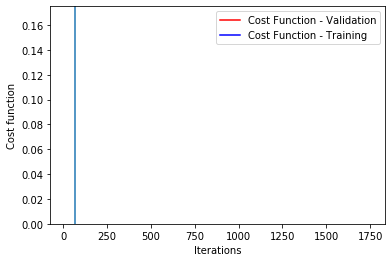

In [20]:
plt.plot(ls_val, color = 'red', label="Cost Function - Validation")
plt.plot(ls_training, color = 'blue', label ="Cost Function - Training")
plt.axvline(x=best_it_idx)
plt.ylim(0, 0.175)
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.legend()
plt.show()

### Test model

In [11]:
# Predict probability
prob = sigmoid(np.dot(X_test, theta))
y_pred = prob >= threshold
y_pred

array([False,  True,  True, False, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False, False,
        True,  True, False,  True,  True, False,  True, False, False,
       False,  True, False,  True,  True, False,  True, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False,  True, False, False,  True, False,  True,  True,
       False, False, False, False,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,

### Metrics

Accuracy: 0.9810725552050473
F1 Score: 0.982142857142857


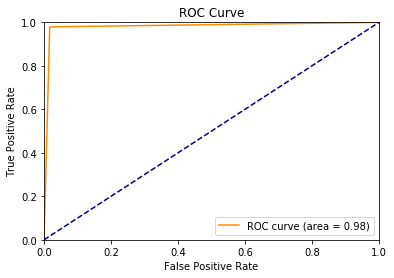

In [12]:
# Accuracy
print('Accuracy: {}'.format((y_pred == y_test).mean()))

# F1 Score
print('F1 Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Choosing threshold

Highest Accuracy: 0.9811 - Threshold: 0.50
Highest F1 Score: 0.9821 - Threshold: 0.50
Highest ROC Area: 0.9812 - Threshold: 0.50


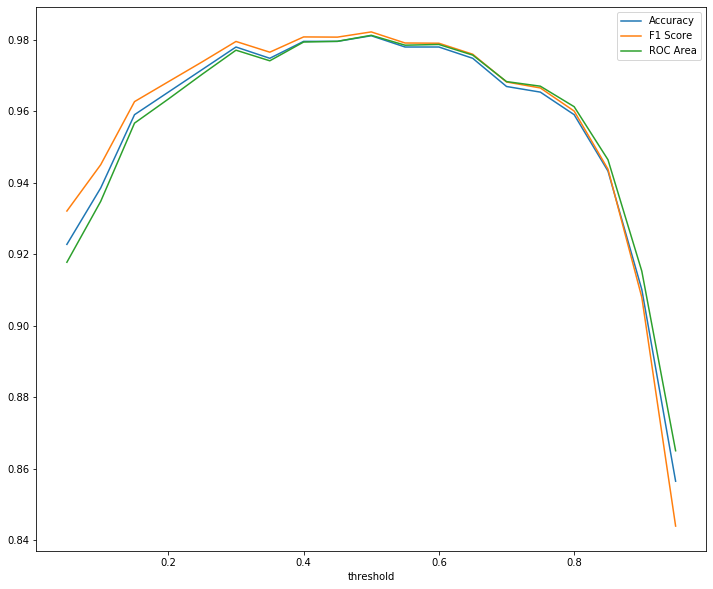

In [33]:
thresholds = np.linspace(0.05,0.95,19)
acc = []
f1s = []
roc = []

for th in thresholds:
    y_pred = prob >= th
    
    # Title
    #print('Threshold: {}'.format(th))
    
    # Accuracy
    #print('Accuracy: {}'.format((y_pred == y_test).mean()))

    # F1 Score
    #print('F1 Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #print('ROC Area: {}'.format(roc_auc))
    
    #print('---------------------------------------')
    
    '''
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()    
    '''
    
    acc.append((y_pred == y_test).mean())
    f1s.append(f1_score(y_test, y_pred, average='binary'))
    roc.append(roc_auc)
    
print('Highest Accuracy: {0:.4f} - Threshold: {1:.2f}'.format(np.max(acc), thresholds[acc.index(np.max(acc))]))
print('Highest F1 Score: {0:.4f} - Threshold: {1:.2f}'.format(np.max(f1s), thresholds[f1s.index(np.max(f1s))]))
print('Highest ROC Area: {0:.4f} - Threshold: {1:.2f}'.format(np.max(roc), thresholds[roc.index(np.max(roc))]))
    
plt.figure(figsize = (12,10))
plt.plot(thresholds, acc, label='Accuracy')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, roc, label='ROC Area')
plt.xlabel('threshold')
plt.legend()
plt.show()

Accuracy for threshold 0.50: 0.9811


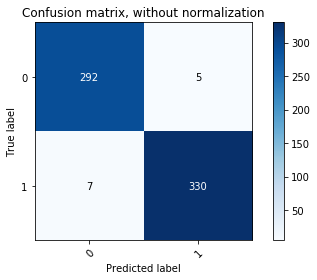

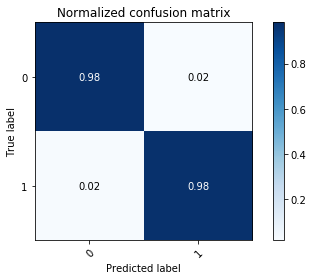

In [12]:
# Most adequate threshold (largest roc area?)
th = 0.5
y_pred = prob >= th

# Accuracy
print('Accuracy for threshold {0:.2f}: {1:.4f}'.format(th, (y_pred == y_test).mean()))

# Confusion matrix
normalize = False
cm = confusion_matrix(y_test, y_pred)
cmap = plt.cm.Blues
classes = ['0', '1']

for normalize in [False, True]:

    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

